# Prefix

This notebook is an implementation of "A simple firing-rate model of working memory and decision-making" by Xiao-Jing Wang. Please refer to https://github.com/computational-neuroscience/wang-project/blob/master/project_instructions.pdf. 

The basic idea is that we're simulating two 'neural assemblies'. Although, there's nothing actually aggregative (there are no spiking neurons, just a continuously-valued firing rate equation). These two assemblies are internally reinforcing, and mutually inhibiting.

<img src="wangimage.png",width=500,height=500>

This simulation will be a model of both attention and decision.
* Attention: can a neural assembly keep its activation going after an input has stopped - so maybe it's more like short-term memory.
* Decision: given two inputs, can one assembly outcompete the other and 'win' (become the only active assembly).

In [1]:
# So, here we go...
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Firing rate equation

The firing rate equation. Leaky integrate and fire? I don't like magic numbers (excuse me, 'hyperparameters').

In [2]:
a = 270
b = 108
d = 0.154

def F(I):
    v = a*I - b
    return v / (1.0 - np.exp(-d*v))

Let's graph F(I) vs. I. Note the discontinuity at 0.4. Doesn't seem to affect simulations further on. If we have to, we can add a correction for 0.4...

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


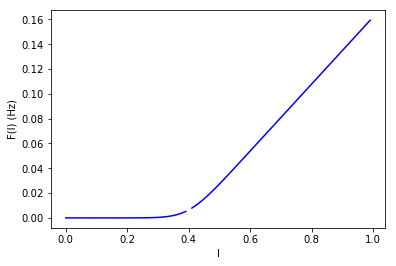

In [3]:
X = np.arange(0.0, 1.0, .01)
plt.plot(X, F(X)/1000.0, "b-")
plt.ylabel('F(I) (Hz)')
plt.xlabel('I')
plt.show()

# Synaptic Drive

I guess I don't have lots to say about this one. See plots of s vs time, below...

In [4]:
gamma = 0.641
phi = 1.0 # phi=1, except for problem 5, but there's no problem 5 in the text. Keep it anyway.
timeconstant = 100.0

def dsdt(I, s):
    f = F(I) / 1000.0
    return phi*(f*gamma*(1.0-s) - s/timeconstant)

# Input Noise

Input has noise given by 'Ornstein-Uhlenbeck process' (https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [5]:
I0 = 0.3255
rho0 = 2
noise_amplitude = 0.02

def dIbdt(Ib):
    v = -(Ib - I0) / rho0 + np.random.normal() * np.sqrt(rho0 * noise_amplitude**2.0)
    return v / rho0

Have a graph of it...

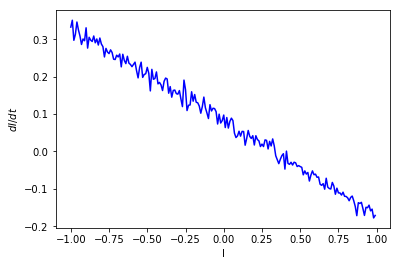

In [6]:
X = np.arange(-1, 1, .01)
y = [dIbdt(x) for x in X]
plt.plot(X, y, "b-")
plt.xlabel('I')
plt.ylabel(r'$dI/dt$')
plt.show()

# Utilities

## Generate input (mu) sequences

In [7]:
def create_mu_sequence(muChanges):
    mus = []
    for muChange in muChanges:
        muTimesteps = muChange[0]
        muValue = muChange[1]
        mus.extend([muValue] * muTimesteps)
    return mus

def create_mu_pulse_3000(mu):
    return create_mu_sequence([(500, 0), (1000, mu), (1500, 0)])

## Utilities to plot things

In [8]:
def plot_seq(timesteps, s1, s2, label1, label2, ylabel, drawXLabelValues=True):
    plt.plot(timesteps, s1, "b-", label=label1, alpha=0.7)
    plt.plot(timesteps, s2, "r-", label=label2, alpha=0.7)
    plt.ylabel(ylabel)
    if not drawXLabelValues:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
    plt.legend(loc="upper left", fontsize=11)

def plot_Mu(timesteps, mu1, mu2, drawXLabelValues=True):
    plot_seq(timesteps, mu1, mu2, r'$\mu_1$', r'$\mu_2$', r'$\mu_i$', drawXLabelValues)
    
def plot_R(timesteps, r1, r2):
    plot_seq(timesteps, r1, r2, r'$r_1$', r'$r_2$', r'$r_i$')

def plot_I(timesteps, i1, i2):
    plot_seq(timesteps, i1, i2, r'$i_1$', r'$i_2$', r'$i_i$')
    
def plot_S(timesteps, s1, s2):
    plot_seq(timesteps, s1, s2, r'$s_1$', r'$s_2$', r'$s_i$')
    
def plot_phase(s1, s2, xlabel, ylabel, title):
    plt.plot(s1, s2, '-+', alpha=0.08)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
def plot_R_phase(r1, r2):
    plot_phase(r1, r2, r'$r_1$', r'$r_2$', r'Phase space: $r_1$ vs $r_2$')
    
def plot_S_phase(s1, s2):
    plot_phase(s1, s2, r'$s_1$', r'$s_2$', r'Phase space: $s_1$ vs $s_2$')
    
def plot_psychometric(c_levels, y_values, ylabel, title):
    plt.plot(np.log(c_levels), y_values, "+-")
    plt.ylabel(ylabel)
    plt.xlabel("log c'")
    plt.title(title, fontsize=16)

# Simulation Code

In [9]:
# urgh, more magic numbers
gE = 0.2609
gI = 0.0497
gext = 0.00052

def simulate(MU1, MU2):
    np.random.seed()
    vals = []
    
    s1 = 0.1
    s2 = 0.1
    Ib1 = 0
    Ib2 = 0
    totalTime = len(MU1)
    
    for t in range(0, totalTime):
        mu1 = MU1[t] 
        mu2 = MU2[t]
        Ib1 = Ib1 + dIbdt(Ib1)
        Ib2 = Ib2 + dIbdt(Ib2)
        i1 = gE*s1 - gI*s2 + Ib1 + gext*mu1
        i2 = gE*s2 - gI*s1 + Ib2 + gext*mu2
        r1 = F(i1)
        r2 = F(i2)
        s1 = s1 + dsdt(i1, s1)
        s2 = s2 + dsdt(i2, s2)
        vals.append([t, mu1, mu2, i1, i2, r1, r2, s1, s2])
        
    return np.array(vals).transpose()

# Task 1

## Run a simulation, plot mu (the input), i1 and i2, r1 and r2, s1 and s2, and the two phase diagrams.

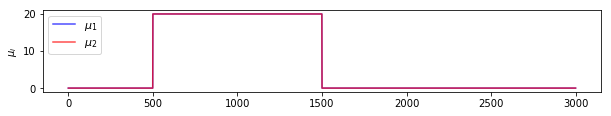

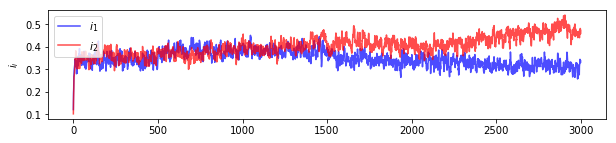

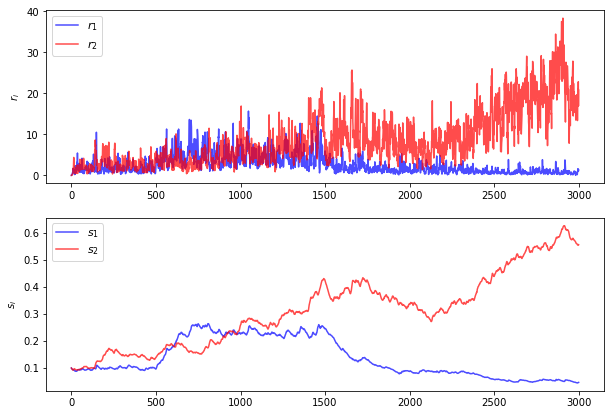

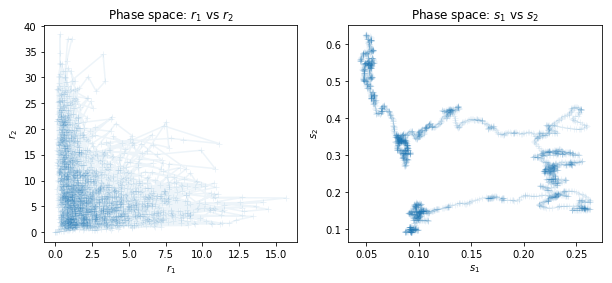

In [10]:
k = simulate(create_mu_pulse_3000(20), create_mu_pulse_3000(20))

timesteps = k[0]
mu1 = k[1]
mu2 = k[2]
i1 = k[3] 
i2 = k[4] 
r1 = k[5] 
r2 = k[6] 
s1 = k[7] 
s2 = k[8] 

plt.figure(figsize=(10,1.5))
plot_Mu(timesteps, mu1, mu2)

plt.figure(figsize=(10,2))
plot_I(timesteps, i1, i2)

plt.figure(figsize=(10,7))
plt.subplot(211)
plot_R(timesteps, r1, r2)

plt.subplot(212)
plot_S(timesteps, s1, s2)

plt.show()


plt.figure(figsize=(10, 4))

plt.subplot(121)
plot_R_phase(r1, r2)

plt.subplot(122)
plot_S_phase(s1, s2)
           
plt.show()

OK, so here we can see both the 'decision' and the 'attention' ideas. Given two identical stimuli (mu1 & mu2 are the same), the two neural assemblies will battle it out, reinforcing themselves and inhibiting the other. One wins (the 'decision'), and will remain active after the stimulus ends (the 'attention').

## Coin tossing: Now do a bunch of simulations - we can see that it's about 50/50 whether each neural assembly wins

In [11]:
r1wins = 0
r2wins = 0
num_trials = 500
for i in range(0, num_trials):
    k = simulate(create_mu_pulse_3000(20), create_mu_pulse_3000(20))
    r1 = k[5]
    r2 = k[6]
    r1win = r1[2000] > r2[2000]
    if r1win:
        r1wins += 1
    else:
        r2wins += 1
        
print ('R1 wins: ', r1wins, '(', r1wins/num_trials, ')   R2 wins: ', r2wins, '(', r2wins/num_trials, ')')

R1 wins:  237 ( 0.474 )   R2 wins:  263 ( 0.526 )


I'd be really surprised at anything other than roughly 50/50...

# An aside: see what it takes to make the system 'change its mind'...

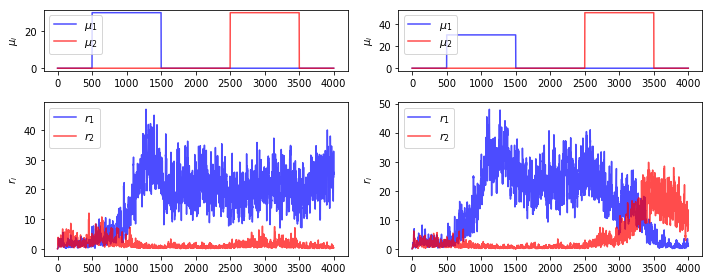

In [12]:
mu1Pulses = [create_mu_sequence([(500, 0), (1000, 30), (2500, 0)]), create_mu_sequence([(500, 0), (1000, 30), (2500, 0)])]
mu2Pulses = [create_mu_sequence([(2500, 0), (1000, 30), (1000, 0)]), create_mu_sequence([(2500, 0), (1000, 50), (1000, 0)])]

plt.figure(figsize=(10, 4))

for i in range(0, 2):
    k = simulate(mu1Pulses[i], mu2Pulses[i])

    timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]

    plt.subplot2grid((3, 2), (0, i), rowspan=1)
    plot_Mu(timesteps, mu1, mu2)

    plt.subplot2grid((3, 2), (1, i), rowspan=2)
    plot_R(timesteps, r1, r2)

plt.tight_layout()
plt.show()

Well, that's disappointing. Or is it? In the left graphs, a pulse for assembly 1 is followed by a pulse for assembly 2, but the second doesn't cause a change. In the right graph, it does, because the second pulse is stronger. Wonder if that's 'good' or 'bad'...

# Task 2: Psychometric function of coherence level

At difference 'coherence levels' (see the text), measure the fraction of correct decisions (let's call that 'accuracy'). Plot that versus log(c'). Also, for each coherence level, plot the first run.

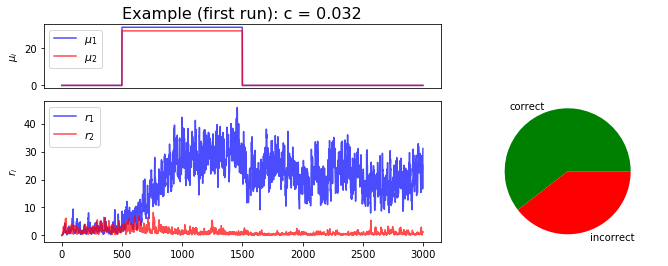

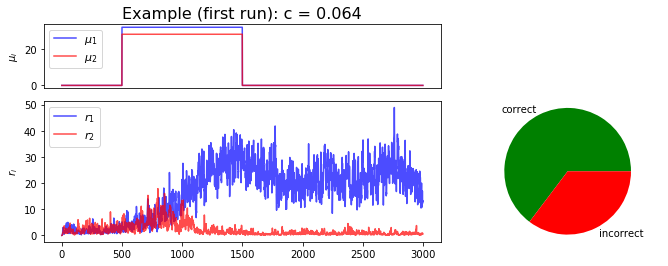

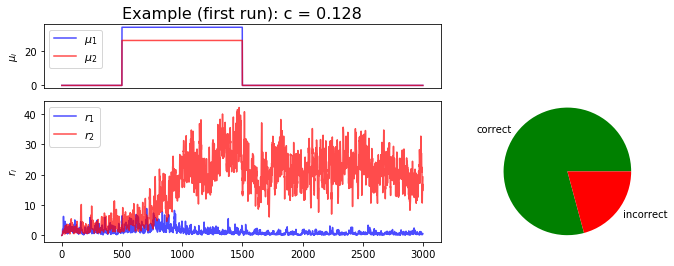

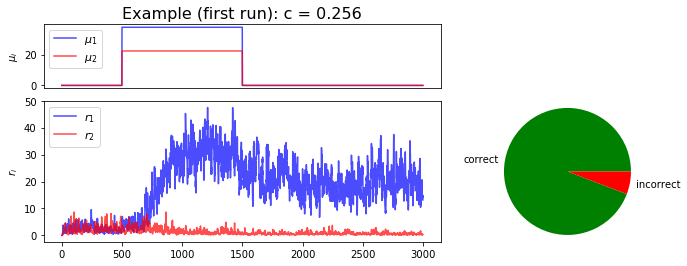

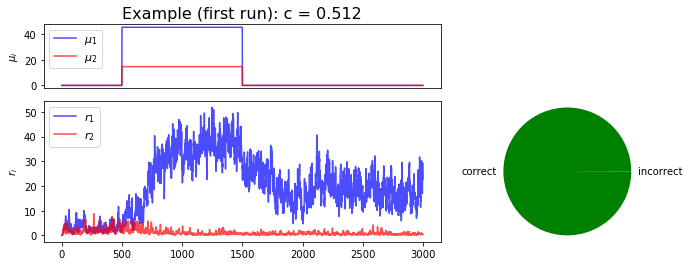

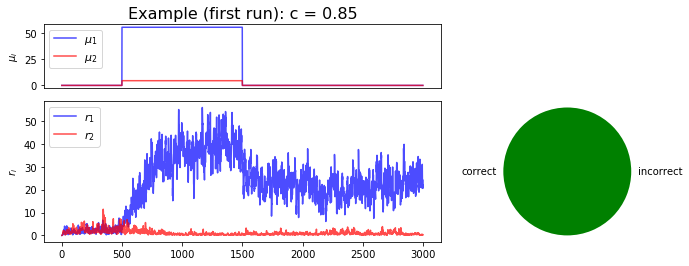

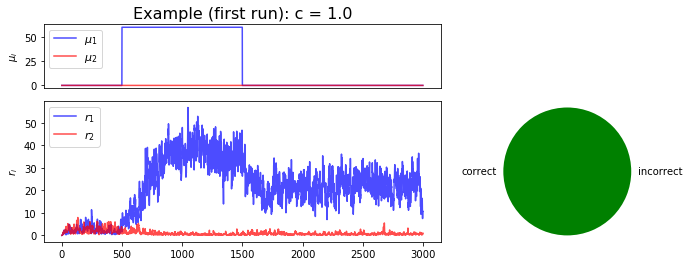

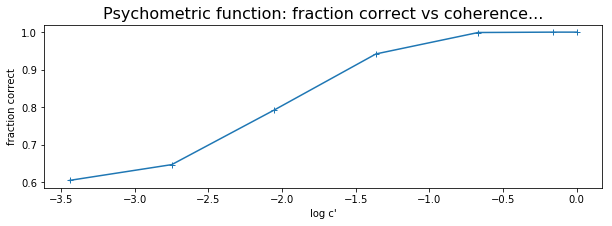

In [13]:
c_levels = [ 0.032, 0.064, 0.128, 0.256, 0.512, 0.85, 1.0 ]
fraction_correct_decisions = []
num_trials = 1000
nc = len(c_levels)

for i, c in enumerate(c_levels):
    mu1v = 30.0 * (1.0 + c)
    mu2v = 30.0 * (1.0 - c)
    mu1Pulses = create_mu_pulse_3000(mu1v)
    mu2Pulses = create_mu_pulse_3000(mu2v)
    
    num_correct = 0
    
    for n in range(0, num_trials):
        k = simulate(mu1Pulses, mu2Pulses)

        timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]
        r1wins = r1[2000] > r2[2000]
        correct = r1wins if mu1v > mu2v else not r1wins
        num_correct += correct
        
        if n == 0:
            
            plt.figure(figsize=(11,4))
            
            plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=1)
 
            plot_Mu(timesteps, mu1, mu2, False)
            plt.title('Example (first run): c = ' + str(c), fontsize=16)
 
            plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
            plot_R(timesteps, r1, r2)

    
    fraction_correct = num_correct / num_trials
    fraction_correct_decisions.append(fraction_correct)
     
    plt.subplot2grid((3, 3), (1, 2), colspan=1, rowspan=2)
    plt.pie([fraction_correct, 1.0-fraction_correct], colors=['g', 'r'], labels=['correct', 'incorrect'])
    plt.axis('equal')
   
plt.figure(figsize=(10,3))
plot_psychometric(c_levels, fraction_correct_decisions, 'fraction correct', 'Psychometric function: fraction correct vs coherence...')
plt.show()

# Task 3: Reaction time

Set the 'decision threshhold' at 15 Hz. The first assembly to reach that is the winner - use it to measure the reaction time, and generate a graph of reaction time vs coherence. Also, plot the first run for each coherence level, and include the threshhold (the horizontal cyan line), and the time at which the first assembly reach threshhold (the vertical line in the same color as the threshhold: blue is first, red is second).

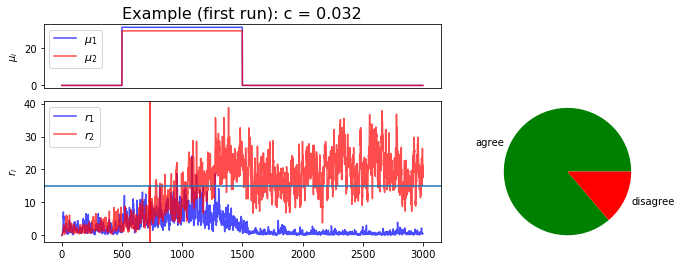

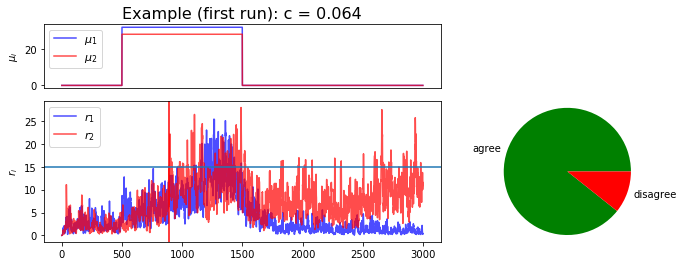

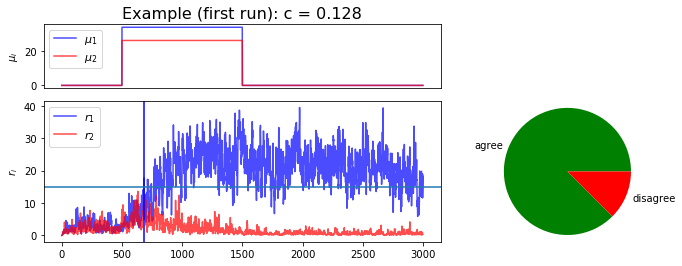

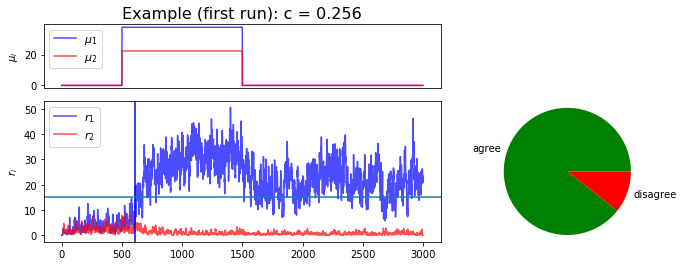

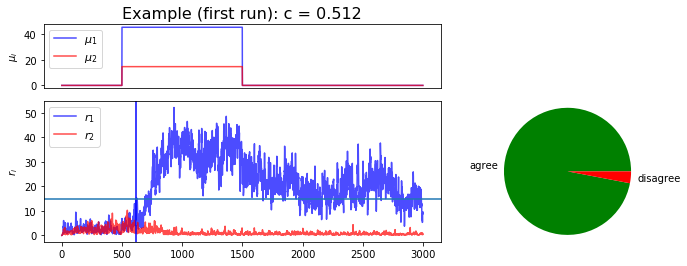

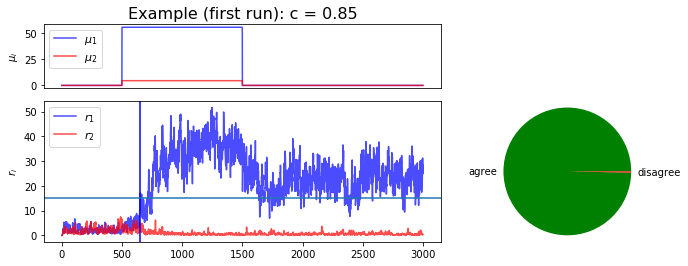

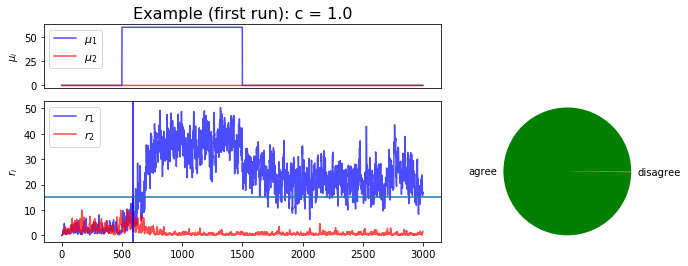

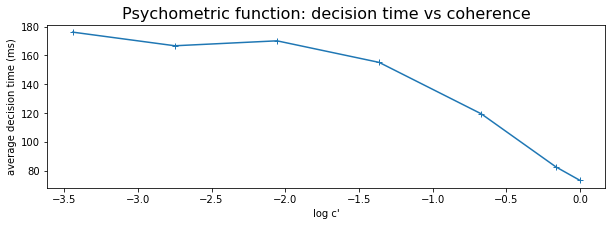

In [14]:
firing_rate_decision_threshhold = 15.0

def index_and_time_of_threshold_exceeded(r1, r2):
    for i, (rv1, rv2) in enumerate(zip(r1, r2)):
        if rv1 >= firing_rate_decision_threshhold:
            return (1, i)
        elif rv2 >= firing_rate_decision_threshhold:
            return (2, i)
    return (0, 0)

decision_times = []
decision_precisions = []
num_trials = 1000

for i, c in enumerate(c_levels):
    mu1v = 30.0 * (1.0 + c)
    mu2v = 30.0 * (1.0 - c)
     
    mu1Pulses = create_mu_pulse_3000(mu1v)
    mu2Pulses = create_mu_pulse_3000(mu2v)
    
    total_decision_time = 0
    total_agreement = 0
    
    for n in range(0, num_trials):
        k = simulate(mu1Pulses, mu2Pulses)

        timesteps, mu1, mu2, r1, r2 = k[0], k[1], k[2], k[5], k[6]
        
        r1wins = r1[2000] > r2[2000]
        
        index_of_decider, time_of_decision = index_and_time_of_threshold_exceeded(r1[500:], r2[500:])
        total_decision_time += time_of_decision
        
        decision_agreement = index_of_decider == 1 if r1wins else index_of_decider == 2
        total_agreement += decision_agreement
        
        if n == 0:
            
            plt.figure(figsize=(11,4))
            
            plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=1)
 
            plot_Mu(timesteps, mu1, mu2, False)
            plt.title('Example (first run): c = ' + str(c), fontsize=16)
 
            plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
            plot_R(timesteps, r1, r2)
        
            # draw the time the first assembly reach threshhold, and the threshhold
            plt.axvline(x=time_of_decision+500, color='b' if index_of_decider == 1 else 'r')
            plt.axhline(y=firing_rate_decision_threshhold)

    decision_time = total_decision_time / num_trials
    decision_precision = total_agreement / num_trials
    
    decision_times.append(decision_time)
    decision_precisions.append(decision_precision)
    
    plt.subplot2grid((3, 3), (1, 2), colspan=1, rowspan=2)
    plt.pie([decision_precision, 1.0-decision_precision], colors=['g', 'r'], labels=['agree', 'disagree'])
    plt.axis('equal')
   
plt.figure(figsize=(10,3))
plot_psychometric(c_levels, decision_times, 'average decision time (ms)', 'Psychometric function: decision time vs coherence')
plt.show()

Scratch an itch: the first assembly to reach the decision threshhold might not be the one the eventually wins out. So, also plot 'decision precision' vs coherence, where the decision precision == 1 if all measurements of wins-by-first-to-threshhold agree with all measurements of wins by greatest firing rate at t=2000.

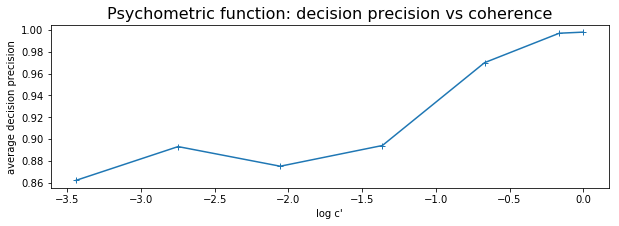

In [15]:
plt.figure(figsize=(10,3))
plot_psychometric(c_levels, decision_precisions, 'average decision precision', 'Psychometric function: decision precision vs coherence')
plt.show()

# Conclusion

What's the takeaway from all this?

I have a problem, semantically, with **coherence**. If 'coherence' == 0, according the equation in the text, that means the signals are perfectly the same, and at == 1, they are completely different. But: if I were to say to you: "two signals have high coherence", wouldn't you think that meant that they are very similar? But in fact, it means the opposite.

I also have a problem with the psychometric function: why log(c')? Why not just c'? Anyway...

The experiments show:
* the higher the coherence, the more accurate the performance of the model
* the higher the coherence, the faster the reaction time
* the higher the coherence, the more precise the performance of the model

This all makes sense: given two competing signals, if they are very similar, it will be difficult to decide between them, and slow, and more error-prone. Not surprising.

Do we like this model? I have some problems with it:
* Using firing rates instead of actual spiking models seems lame. Like, all the interesting stuff, imho, is in the question: how do assemblies of spiking neurons generate this type of behavior?
* There are just way too many magic numbers. Do they correlate to actual biology? No idea.
* Only 2 assemblies. I know we need to start somewhere. Maybe I'll extend it to multiple assemblies, but my guess is that I'd then be stuck in infinite parameter search, to make everything work out.

Maybe more relevant is the tests we applied to the model: any model, or implementation of decision making and memory should exhibit the behavior we see relative to coherence of input signals. And more besides (such as 'mind-changing'). So what we learned is more of the 'what questions to ask' type of thing.